# Extraction and plot of CPU power consumption from DGEMM archives

In [1]:
archive_names = [
    'grenoble_2020-11-02_1954419.zip',
    'grenoble_2020-11-09_1957362.zip',
    'grenoble_2020-11-12_1957985.zip',
    'grenoble_2020-12-08_1966627.zip',
]

In [2]:
import io
import zipfile
import requests
import pandas
import re
import numpy
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction as ae

def download_file(archive_name, base_url='https://gitlab.in2p3.fr/cornebize/g5k_data_non_regression/-/raw/master/data/'):
    data = requests.get(base_url + archive_name)
    if data.status_code != 200:
        raise ValueError(f'Could not download the file, got an error {data.status_code}')
    return io.BytesIO(data.content)

c0a430e3a498fc690b6244ca9909444040c28128


In [3]:
archives = [download_file(name) for name in archive_names]

In [4]:
import re
import numpy

reg = re.compile('power_package-(?P<cpu_id>[0-9]+)(_(?P<sub_group>[a-z]+))?')
reg.fullmatch('power_package-1').groupdict()

def melt_power(df, idcol):
    reg = re.compile('power_package-(?P<cpu_id>[0-9]+)(_(?P<sub_group>[a-z]+))?')
    result = []
    columns = list(df.columns)
    for col in columns:
        match = reg.fullmatch(col)
        if match is None:
            continue
        tmp = df[idcol].copy()
        tmp['value'] = df[col]
        tmp['cpu'] = int(match.groupdict()['cpu_id'])
        tmp['subgroup'] = str(match.groupdict()['sub_group'])
        result.append(tmp)
    return pandas.concat(result)

def read_monitoring_power(archive_name, columns=None):
    '''
    Read the durations of a BLAS calibration in an archive.
    '''
    csv_name = 'monitoring.csv'
    df = ae.read_archive_csv_enhanced(archive_name, csv_name, columns=columns)
    df['timestamp'] = pandas.to_datetime(df['timestamp'])
    columns = ['timestamp', 'cluster', 'node', 'jobid', 'start_time', 'expfile_hash']
    power = melt_power(df, columns)
    power['timestamp'] = power['timestamp'].astype(numpy.int64) / 10 ** 9
    info = ae.read_yaml(archive_name, 'info.yaml')
    timestamps = info['timestamp']
    for step in ['start', 'stop']:
        power[f'{step}_exp'] = pandas.to_datetime(timestamps['run_exp'][step]).timestamp()
    power['in_exp'] = (power['timestamp'] >= power['start_exp']) & (power['timestamp'] <= power['stop_exp'] - 100)
    power['timestamp'] = power['timestamp'] - power['timestamp'].min()
    return power

dataframes = []
for f in archives:
    tmp = read_monitoring_power(f)
    tmp['expfile'] = ae.read_yaml(f, 'info.yaml')['expfile'][0]
    dataframes.append(tmp)
power = pandas.concat(dataframes)

power['date'] = pandas.to_datetime(power['start_time'], unit='s').dt.date

power.head()

,timestamp,cluster,node,jobid,start_time,expfile_hash,value,cpu,subgroup,start_exp,stop_exp,in_exp,expfile,date
0,0.024027,dahu,2,1954419,1604301624,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,52.901438,1,None,1.604306e+09,1.604307e+09,False,exp.csv,2020-11-02
1,10.030594,dahu,2,1954419,1604301624,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,59.848945,1,None,1.604306e+09,1.604307e+09,False,exp.csv,2020-11-02
2,20.040660,dahu,2,1954419,1604301624,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,49.834213,1,None,1.604306e+09,1.604307e+09,False,exp.csv,2020-11-02
3,30.050797,dahu,2,1954419,1604301624,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,36.699571,1,None,1.604306e+09,1.604307e+09,False,exp.csv,2020-11-02
4,40.109642,dahu,2,1954419,1604301624,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,16.590248,1,None,1.604306e+09,1.604307e+09,False,exp.csv,2020-11-02


In [5]:
def plot_evolution(df, y_val):
    df = df.copy()
    for jobid in df['jobid'].unique():
        df.loc[df['jobid'] == jobid, 'timestamp'] -= df[df['jobid'] == jobid]['timestamp'].min()
    return (ggplot(df)
           + aes(x='timestamp', y=y_val, color='factor(cpu)')
           + geom_line()
           + theme_bw()
           + facet_wrap(['date', 'jobid'], labeller='label_both')
           + labs(color='CPU', x='Timestamp (s)')
           + guides(color = guide_legend(override_aes = {'alpha': 1, 'size': 2}))

    )


def filter_dates(df, *dates):
    dates = {pandas.to_datetime(d).date() for d in dates}
    return df[df['date'].isin(dates)]

def filter_nodes(df, *nodes):
    nodes = set(nodes)
    return df[df['node'].isin(nodes)]

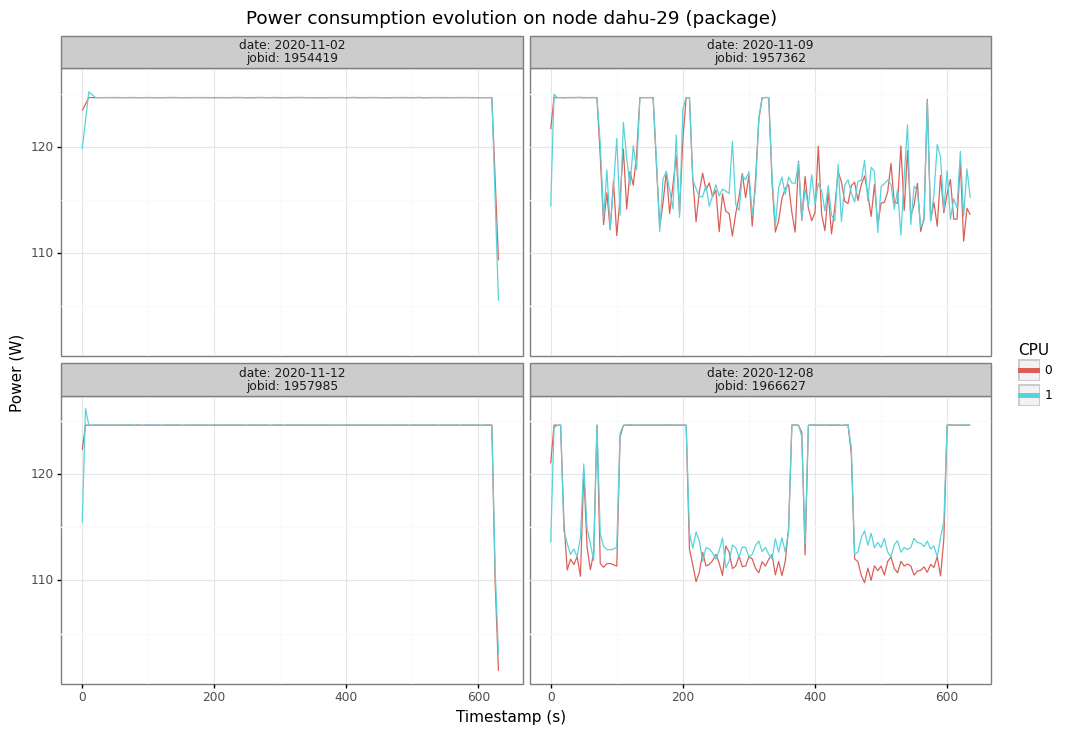

<ggplot: (8771063959507)>


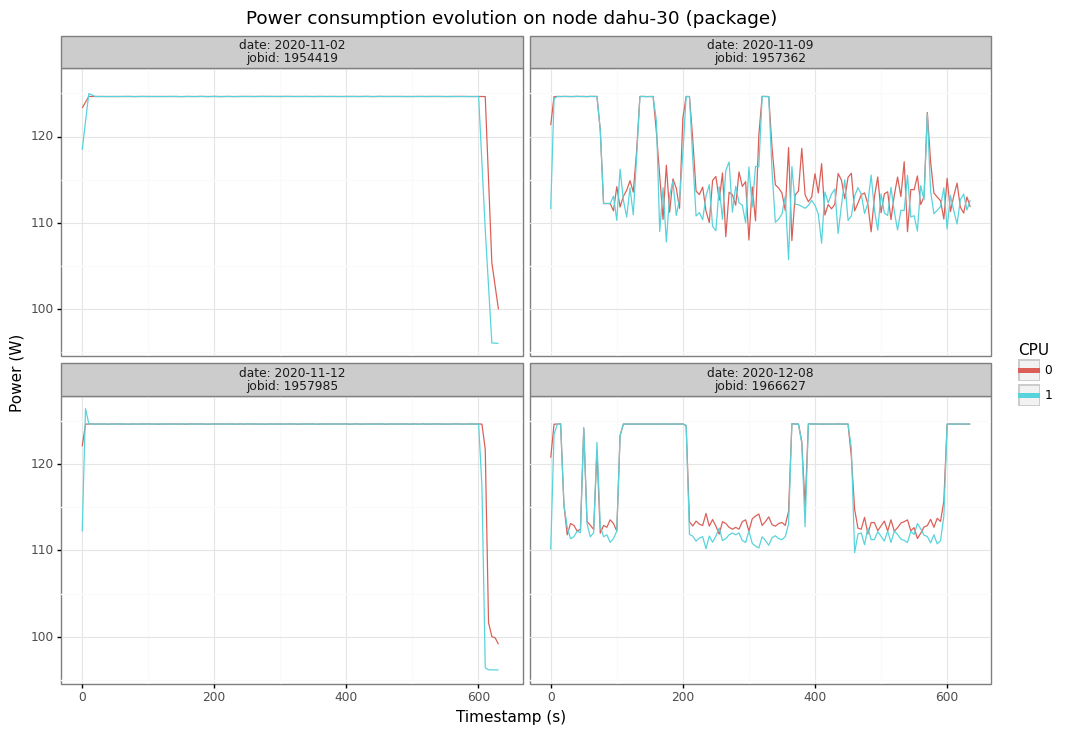

<ggplot: (-9223363265793066159)>


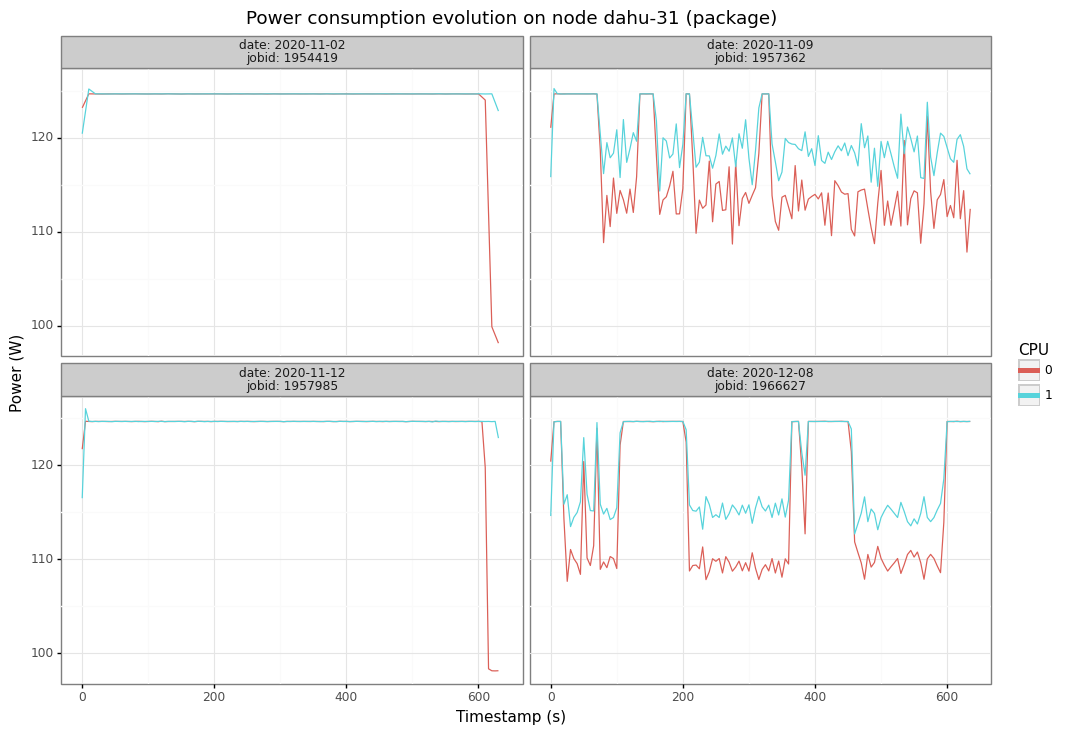

<ggplot: (8771061585458)>


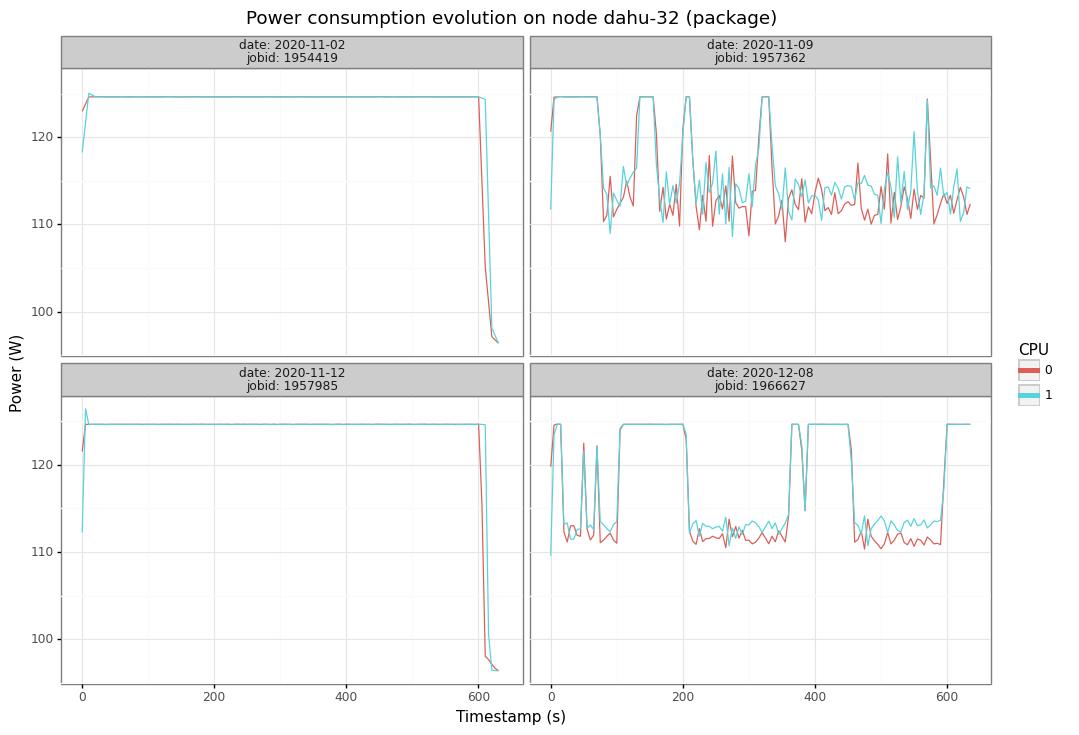

<ggplot: (-9223363265793303117)>


In [6]:
for node in [29, 30, 31, 32]:
    print(plot_evolution(filter_nodes(power[(power['subgroup'] == 'None') & (power['in_exp'])], node), 'value')
        + ggtitle(f'Power consumption evolution on node dahu-{node} (package)')
        + ylab('Power (W)')
        + expand_limits(y=(110, 125))
    )